In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import geopandas as gpd

df = pd.read_csv("../CSV/2010-2021.csv")

# create grouping of data using specified column
groupby_borough = df.groupby(['BOROUGH'])

# creates a copy of specified entry within the column group
manhattan = groupby_borough.get_group(('MANHATTAN',)).copy()
manhattan.drop('LOWEST SALE PRICE', axis=1, inplace=True)
manhattan.drop('HIGHEST SALE PRICE', axis=1, inplace=True)

# group further by home type
groupby_home = manhattan.groupby(['TYPE OF HOME'])
two = groupby_home.get_group(('02 TWO FAMILY HOMES',)).copy()

# set up to do regession 
hood_names_two = two['NEIGHBORHOOD'].unique()
groupby_hood = two.groupby(['NEIGHBORHOOD'])
# addresses small samples
small_sample = ["CHINATOWN", "JAVITS CENTER", "LITTLE ITALY"] 

# prediction model
dic_two = {}
for h in hood_names_two:
    temp = groupby_hood.get_group((h,)).copy()
    # print(h)
    if h in small_sample:
        dic_two[h] = temp['AVERAGE SALE PRICE'].item()
    else:
        X = temp[['YEAR', 'MEDIAN SALE PRICE', 'NUMBER OF SALES']]
        y = temp['AVERAGE SALE PRICE']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        dic_two[h] = y_pred[0]

# map of manhattan neighborhood
shape = gpd.read_file("../nynta2020_24b/nynta2020.shp")

# removes all borough that isn't Manhattan
to_drop = shape[shape["BoroName"] != "Manhattan"].index 
shape.drop(to_drop, inplace=True) 

# removes all other columns that we don't really care for
shape = shape.drop(columns=["BoroCode", "BoroName", "CountyFIPS", "NTA2020", "NTAAbbrev", "NTAType", "CDTA2020", "Shape_Leng", "Shape_Area", "CDTAName"])

In [2]:
hood_names_two

array(['ALPHABET CITY', 'CHELSEA', 'EAST VILLAGE',
       'GREENWICH VILLAGE-WEST', 'HARLEM-CENTRAL', 'HARLEM-EAST',
       'HARLEM-UPPER', 'HARLEM-WEST', 'INWOOD', 'KIPS BAY',
       'MIDTOWN EAST', 'SOHO', 'UPPER EAST SIDE (59-79)',
       'UPPER EAST SIDE (79-96)', 'UPPER WEST SIDE (59-79)',
       'UPPER WEST SIDE (79-96)', 'WASHINGTON HEIGHTS LOWER', 'GRAMERCY',
       'GREENWICH VILLAGE-CENTRAL', 'MURRAY HILL',
       'UPPER WEST SIDE (96-116)', 'WASHINGTON HEIGHTS UPPER',
       'CHINATOWN', 'LOWER EAST SIDE', 'MANHATTAN VALLEY', 'MIDTOWN WEST',
       'SOUTHBRIDGE', 'CLINTON', 'TRIBECA', 'JAVITS CENTER',
       'LITTLE ITALY'], dtype=object)

In [3]:
hood_matches_two = {
    'Financial District-Battery Park City': 'SOUTHBRIDGE',
    'Tribeca-Civic Center': 'TRIBECA',
    'The Battery-Governors Island-Ellis Island-Liberty Island': None,
    'SoHo-Little Italy-Hudson Square': ['SOHO', 'LITTLE ITALY'],
    'Greenwich Village': 'GREENWICH VILLAGE-CENTRAL',
    'West Village': 'GREENWICH VILLAGE-WEST',
    'Chinatown-Two Bridges': 'CHINATOWN',
    'Lower East Side': 'LOWER EAST SIDE',
    'East Village': 'EAST VILLAGE',
    'Chelsea-Hudson Yards': 'CHELSEA',
    "Hell's Kitchen": 'CLINTON',
    'Midtown South-Flatiron-Union Square': 'MIDTOWN WEST',
    'Midtown-Times Square': 'MIDTOWN EAST',
    'Stuyvesant Town-Peter Cooper Village': None,
    'Gramercy': 'GRAMERCY',
    'Murray Hill-Kips Bay': ['MURRAY HILL', 'KIPS BAY'],
    'East Midtown-Turtle Bay': 'MIDTOWN EAST',
    'United Nations': None,
    'Upper West Side-Lincoln Square': 'UPPER WEST SIDE (59-79)',
    'Upper West Side (Central)': 'UPPER WEST SIDE (79-96)',
    'Upper West Side-Manhattan Valley': 'UPPER WEST SIDE (96-116)',
    'Upper East Side-Lenox Hill-Roosevelt Island': 'UPPER EAST SIDE (59-79)',
    'Upper East Side-Carnegie Hill': 'UPPER EAST SIDE (79-96)',
    'Upper East Side-Yorkville': None,
    'Morningside Heights': None,
    'Manhattanville-West Harlem': 'HARLEM-CENTRAL',
    'Hamilton Heights-Sugar Hill': 'HARLEM-WEST',
    'Harlem (South)': 'HARLEM-EAST',
    'Harlem (North)': 'HARLEM-UPPER',
    'East Harlem (South)': 'HARLEM-EAST',
    'East Harlem (North)': 'HARLEM-UPPER',
    "Randall's Island": None,
    'Washington Heights (South)': 'WASHINGTON HEIGHTS LOWER',
    'Washington Heights (North)': 'WASHINGTON HEIGHTS UPPER',
    'Inwood': 'INWOOD',
    'Highbridge Park': None,
    'Inwood Hill Park': None,
    'Central Park': None
}

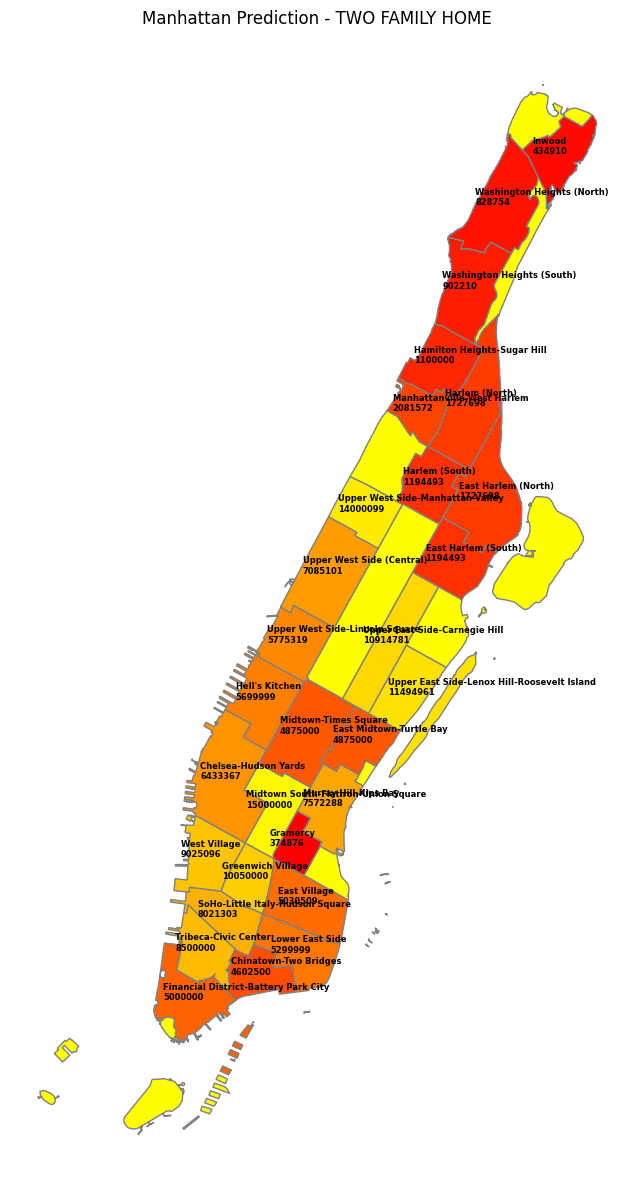

In [4]:
import matplotlib.pyplot as plt

shape['sales'] = "-"

# adding sales data to overall df
for i, row in shape.iterrows():
    holder = hood_matches_two[row['NTAName']]
    if holder:
        if isinstance(holder, list):
            sum = 0
            for e in holder:
                sum += dic_two[e]
            shape.at[i, 'sales'] = int(sum/len(holder))
        else:
            shape.at[i, 'sales'] = int(dic_two[holder])

shape_map = shape.plot(column='sales', k=8, cmap='autumn', figsize=(30,15), linewidth=1, edgecolor='0.5')

for i, row in shape.iterrows():
    x = row['geometry'].centroid.x
    y = row['geometry'].centroid.y
    if row['sales'] != "-" :
        label = row['NTAName'] + "\n" + str(row['sales'])
        shape_map.annotate(label, xy=(x, y), xytext=(-20, 0), color="black", textcoords="offset points", fontsize=6, weight="bold")

shape_map.set(title="Manhattan Prediction - TWO FAMILY HOME")
shape_map.set_axis_off()